In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from scipy.ndimage.filters import gaussian_filter
from collections import Counter, defaultdict
from torch.utils.data import Dataset
from typing import List, Dict
import xarray as xr
import itertools
import logging
import joblib
import random
import torch
import yaml
import sys
import cv2
import os

import pandas as pd
import numpy as np

import logging
import transforms

import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.9.0+cu102'

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

### See [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) for an example on using Sequence with multiprocessing

In [4]:
logger = logging.getLogger(__name__)

In [5]:
class MultiHologramDataset(Dataset):

    def __init__(
            self,
            path_data: List[str],
            output_cols: List[str],
            batch_size: int = 32,
            max_particles: int = 100,
            shuffle: bool = True,
            scaler: Dict[str, str] = True,
            transform = None) -> None:
        
        'Initialization'
        self.ds = {name: xr.open_dataset(name) for name in path_data}
        
        'Load the filenames from the config file'
        self.hologram_numbers = []
        for name, _ds in sorted(self.ds.items()):
            for hologram_number in _ds["hologram_number"].values:
                self.hologram_numbers.append([name, hologram_number])
        
        self.output_cols = [x for x in output_cols if x != 'hid']  
        self.max_particles = max_particles
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.transform = transform
        self.on_epoch_end()
        
        self.scaler = None
        self.set_scaler(scaler)

        logger.info(
            f"Loaded {path_data} hologram data containing {len(self.hologram_numbers)} images"
        )
        
    def set_scaler(self, scaler = True):
        if scaler == True:
            logger.info(f"Rescaling the data by subtracting the mean and dividing by sigma")
            self.scaler = {col: StandardScaler() for col in self.output_cols}  # StandardScaler() MinMaxScaler()
            for col in self.output_cols:
                concat = [arr[col].values for arr in self.ds.values()]
                scale = np.hstack(concat)
                self.scaler[col].fit(scale.reshape(scale.shape[-1], -1))
        elif scaler == False:
            self.scaler = False
        else:
            self.scaler = scaler
        logger.info(f"Loaded data scaler transformation {self.scaler}")

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.hologram_numbers) / self.batch_size))

    def __getitem__(self, idx):    
        'Generate one data point'
        name, hologram = self.hologram_numbers[idx]

        'Update the counter'
        self.processed += 1
        if self.processed == self.__len__():
            self.on_epoch_end()

        im = self.ds[name]["image"][hologram].values
        im = {
            "image": np.expand_dims(im, 0), 
            "horizontal_flip": False, 
            "vertical_flip": False
        }

        'Apply image transformations listed in the config file'
        if self.transform:
            for image_transform in self.transform:
                im = image_transform(im)

        'Load one hologram and get the particles'
        particles = np.where(self.ds[name]["hid"] == hologram + 1)[0]
        y_out = {task: np.zeros((self.max_particles)) for task in self.output_cols}
        y_out_raw = {task: np.zeros((self.max_particles)) for task in self.output_cols}
        for l, p in enumerate(particles):
            indices = []
            for task in self.output_cols:
                val = self.ds[name][task].values[p]
                if im["horizontal_flip"] and task == "x":
                    val *= -1
                if im["vertical_flip"] and task == "y":
                    val *= -1
                y_out_raw[task][l] = val
                'Scaler transform the y-out data'
                if isinstance(self.scaler, dict):
                    val = self.scaler[task].transform(val.reshape(-1, 1))[0][0]
                y_out[task][l] = val

        'Return as numpy arrays'
        image = im["image"]
        y_out = np.stack(list(y_out.values()))
        y_out_raw = np.stack(list(y_out_raw.values()))
        return image, y_out, y_out_raw

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.processed = 0
        if self.shuffle == True:
            random.shuffle(self.hologram_numbers)

### Load a configuration with details on which datasets to load, and how many examples from each

In [6]:
with open("data.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

### Load the image transformations from the config files

In [7]:
train_transforms = transforms.LoadTransformations(conf["train_transforms"])
valid_transforms = transforms.LoadTransformations(conf["validation_transforms"])

### Initialize the data readers

In [8]:
train_reader = MultiHologramDataset(
    **conf["train_data"],
    transform = train_transforms
)

# Save the scaler to file here 

valid_reader = MultiHologramDataset(
    **conf["validation_data"],
    transform = train_transforms,
    scaler = train_reader.scaler
)

### Get one item

In [9]:
x, y, y_raw = train_reader.__getitem__(10000)

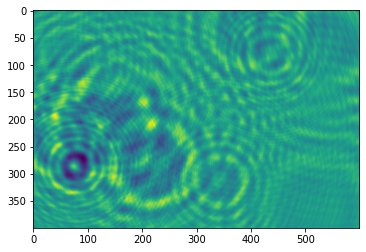

In [10]:
plt.imshow(x.squeeze(0).transpose(1, 0))

### Use torch's FFT methods to propagate the hologram along z

In [11]:
def torch_holo_set(Ein: torch.tensor,
                   fx: torch.tensor,
                   fy: torch.tensor,
                   z_tnsr: torch.tensor,
                   lam: float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

In [12]:
h_ds = list(train_reader.ds.values())[-1]

dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [13]:
n_bins = 10000  # number of bins in histogram
z_bins = np.linspace(h_ds.attrs['zMin'], h_ds.attrs['zMax'], n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers

In [14]:
x_arr = np.arange(-Nx // 2, Ny // 2)*dx
y_arr = np.arange(-Ny // 2, Ny // 2)*dy

In [15]:
fx = torch.fft.fftfreq(Nx, dx, device=device).unsqueeze(0).unsqueeze(-1) #[None,:,None]
fy = torch.fft.fftfreq(Ny, dy, device=device).unsqueeze(0).unsqueeze(0) #[None,None,:]
z_rec = torch.tensor(z_centers*1e-6, device=device).unsqueeze(-1).unsqueeze(-1) #[:,None,None]

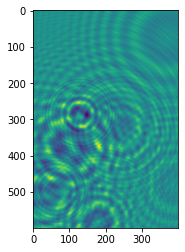

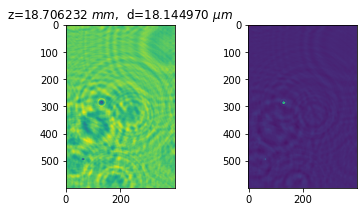

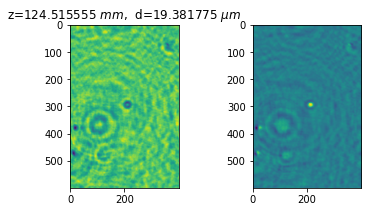

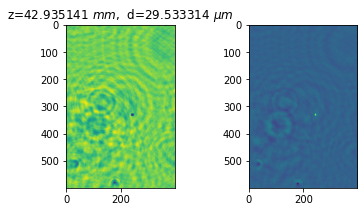

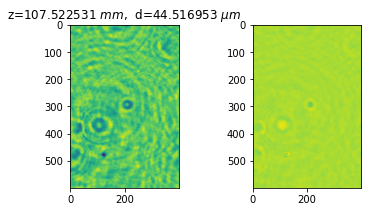

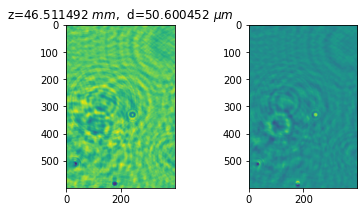

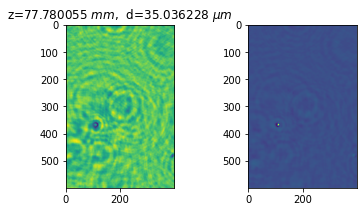

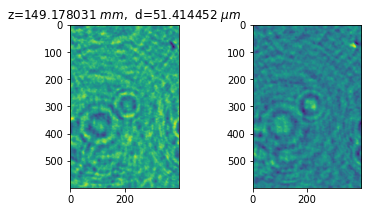

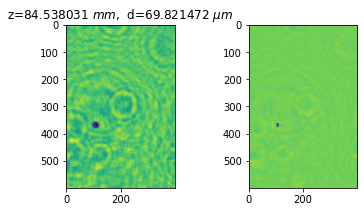

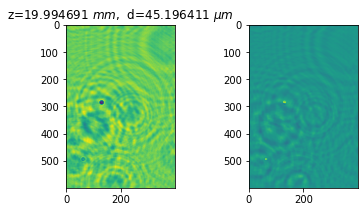

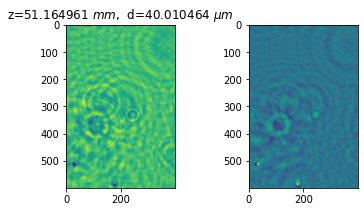

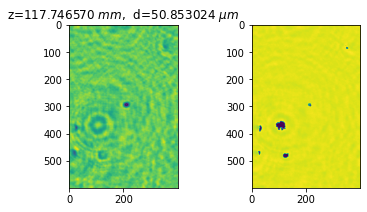

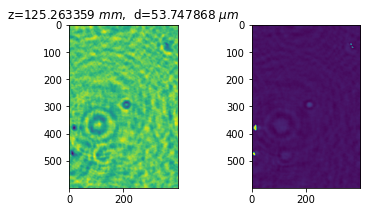

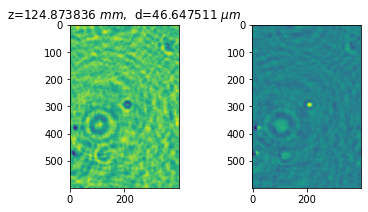

In [16]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]

z_plane = torch.tensor(zp*1e-6,  device=device).unsqueeze(-1).unsqueeze(-1) #[:,None,None]

E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values, 
                       device = device, 
                       dtype = torch.complex64).squeeze(0) #[None,:,:]

Eres = torch_holo_set(E_input, fx, fy, z_plane, lam).detach().cpu().numpy()

plt.imshow(h_ds['image'].isel(hologram_number=holo_idx).values / 255.0)

for idx, z in enumerate(zp):
    fig, ax = plt.subplots(1,2,figsize=(6,3))
    ax[0].imshow(np.abs(Eres[idx,:,:])/255.0)
    ax[0].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$,  d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].imshow(np.angle(Eres[idx,:,:])/255.0)
    ax[1].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)

In [17]:
class Propagator:
    
    def __init__(self, train_reader, n_bins = 10000):
        
        h_ds = list(train_reader.ds.values())[-1]
        dx = h_ds.attrs['dx']      # horizontal resolution
        dy = h_ds.attrs['dy']      # vertical resolution
        Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
        Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = h_ds.attrs['lambda'] # wavelength
        zMin = h_ds.attrs['zMin']  # minimum z in sample volume
        zMax = h_ds.attrs['zMax']  # maximum z in sample volume
        zCCD = 0                   # z position of the image plane
        image_norm = 255.0
        
        self.z_bins = np.linspace(h_ds.attrs['zMin'], h_ds.attrs['zMax'], n_bins)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers
        self.labels = np.arange(n_bins) # label 0 will refer to images with no particles in focus
        
        x_arr = np.arange(-Nx / 2, Ny / 2)*dx
        y_arr = np.arange(-Ny / 2, Ny / 2)*dy
        
        self.fx = torch.fft.fftfreq(Nx, dx, device=device).unsqueeze(0).unsqueeze(-1)
        self.fy = torch.fft.fftfreq(Ny, dy, device=device).unsqueeze(0).unsqueeze(0)
        z_rec = torch.tensor(self.z_centers*1e-6, device=device).unsqueeze(-1).unsqueeze(-1)
        
    def prop(self, image, coordinates):
        
        image = image.squeeze(0)

        # Remove any of the fake particles (which were needed to make fixed batch sizes by the torch iterator)
        # This will get updated and simplified later
        stop = np.where(coordinates[3, :] == 0.0)[0]
        stop = coordinates.shape[0] if len(stop) == 0 else stop[0]
        coordinates = coordinates[:, :stop]
        sort_by = np.argsort(coordinates[2]) # sort smallest-to-largest along z
        
        # Sort the particles in the hologram by z (smallest first)
        coordinates = coordinates[:, sort_by]
        z_bin_labels = [np.digitize(zzp, self.z_bins) for zzp in coordinates[2]]
        
        # Select equal number of z values that dont have any particles in focus
        # to use as negative examples
        not_in_focus_bins = [x for x in self.labels if x not in z_bin_labels]      
        not_in_focus_selection = random.sample(not_in_focus_bins, coordinates.shape[1])
        z_selection = self.z_bins[not_in_focus_selection]
        negative_examples = np.zeros(coordinates.shape)    
        negative_examples[2, :] = z_selection
        
        # Create labels for the images (0 for out-of-focus, 1 for in-focus)
        z_bin_labels = [1 for x in z_bin_labels]
        z_bin_labels += [0 for x in z_selection]
        
        # Put the two together
        coordinates = np.hstack([coordinates, negative_examples])
        
        # Select the (x,y,z,d) coordinates for the particles
        xp = coordinates[0] #h_ds['x'].values[p_idx]
        yp = coordinates[1] #h_ds['y'].values[p_idx]
        zp = coordinates[2] #h_ds['z'].values[p_idx]
        dp = coordinates[3] #h_ds['d'].values[p_idx]
          
        # Propagate the images along the z values supplied
        z_plane = torch.tensor(zp*1e-6,  device=device).unsqueeze(-1).unsqueeze(-1)
        E_input = torch.tensor(image, 
                               device = device, 
                               dtype = torch.complex64).squeeze(0)
        Eres = self.torch_holo_set(E_input, self.fx, self.fy, z_plane, self.lam).detach()#.cpu().numpy()
        recon_image = torch.abs(Eres)
        recon_angle = torch.angle(Eres)
        # Create torch tensor of the binary labels for the images
        labels = torch.LongTensor(z_bin_labels).unsqueeze(-1)
        # Use the reconstructed image and the phase (stack on the color channel so 2 channels)   
        return_stack = torch.stack([recon_image, recon_angle], 1)
        return return_stack.float(), labels.to(device)
        
#         plt.imshow(image)
#         for idx, z in enumerate(zp): 
#             fig, ax = plt.subplots(1,2,figsize=(6,3))    
#             ax[0].imshow(recon_image[idx])
#             ax[0].scatter(yp[idx]*1e-6, xp[idx]*1e-6, c='r', s=2,alpha=0.3)
#             ax[0].set_title('z=%f $mm$,  d=%f $\mu m$'%(z*1e-3,dp[idx]))
#             ax[1].imshow(recon_angle[idx])
#             ax[1].scatter(yp[idx]*1e-6, xp[idx]*1e-6, c='r',s=2,alpha=0.3)    
    
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       fx: torch.tensor,
                       fy: torch.tensor,
                       z_tnsr: torch.tensor,
                       lam: float):
        
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
        Eout = torch.fft.ifft2(Eofft)
        return Eout

In [18]:
propagator = Propagator(train_reader)

In [19]:
xp, yp = propagator.prop(x, y_raw)

In [20]:
xp.shape

torch.Size([40, 2, 600, 400])

In [21]:
from torch.utils.data import DataLoader

In [22]:
# Load data iterators from pytorch
train_dataloader = DataLoader(
    train_reader,
    batch_size = 1,
    shuffle = True
)

# Load data iterators from pytorch
valid_dataloader = DataLoader(
    valid_reader,
    batch_size = 1,
    shuffle = True
)

### Train a simple model to predict yes or no

In [23]:
import torchvision.models as models
import torch.nn as nn

from torch.optim.lr_scheduler import *
import tqdm

In [24]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [25]:
fcl_layers = []
dropout = 0.5
output_size = 2
resnet_model = 50

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = True).to(device)

### Test the model on an input from prop

In [26]:
probs = model(xp).exp()
print(probs)

tensor([[0.4406, 0.5594],
        [0.4822, 0.5178],
        [0.3629, 0.6371],
        [0.4905, 0.5095],
        [0.3947, 0.6053],
        [0.6386, 0.3614],
        [0.3339, 0.6661],
        [0.4509, 0.5491],
        [0.4825, 0.5175],
        [0.3322, 0.6678],
        [0.3858, 0.6142],
        [0.5229, 0.4771],
        [0.5881, 0.4119],
        [0.4959, 0.5041],
        [0.4486, 0.5514],
        [0.2771, 0.7229],
        [0.4500, 0.5500],
        [0.4180, 0.5820],
        [0.4805, 0.5195],
        [0.4919, 0.5081],
        [0.3601, 0.6399],
        [0.5974, 0.4026],
        [0.3154, 0.6846],
        [0.4303, 0.5697],
        [0.6211, 0.3789],
        [0.3746, 0.6254],
        [0.4694, 0.5306],
        [0.5377, 0.4623],
        [0.4892, 0.5108],
        [0.6447, 0.3553],
        [0.3394, 0.6606],
        [0.2751, 0.7249],
        [0.3243, 0.6757],
        [0.5974, 0.4026],
        [0.6866, 0.3134],
        [0.3969, 0.6031],
        [0.3653, 0.6347],
        [0.3974, 0.6026],
        [0.5

##### These give the probabilites of predicting labels 0 and 1. The predicted labels is thus:

In [27]:
torch.argmax(probs, 1)

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')

### Load an optimizer

In [28]:
learning_rate = 1e-04
weight_decay = 0.0

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

### Load losses

In [29]:
train_criterion = torch.nn.CrossEntropyLoss()
test_criterion = torch.nn.CrossEntropyLoss() 

In [30]:
# this will help lower the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(
    optimizer, 
    patience = 1, 
    min_lr = 1.0e-10,
    verbose = True
)

In [ ]:
epochs = 200 
train_batch_size = 32
valid_batch_size = 1
batches_per_epoch = 1000

stopping_patience = 5

epoch_test_losses = []

for epoch in range(epochs):

    ### Train the model 
    model.train()

    batch_loss = []
    accuracy = [] 
    
    # How many batches are 1 epoch 
    train_batches_per_epoch = int(train_dataloader.__len__() / train_batch_size) * 25 # if average hologram N = 12.5, generate 25 images per holo
    train_batches_per_epoch = min(batches_per_epoch, train_batches_per_epoch)
    
    # custom tqdm so we can see the progress
    batch_group_generator = tqdm.tqdm(
        enumerate(train_dataloader), 
        total=train_batches_per_epoch * 3, # hacking a little to fix the counter
        leave=True
    )
 
    counter = 0
    p_x, p_y = [], []
    for k, (x, y, y_raw) in batch_group_generator:
        
        # propagate the hologram to the z values
        inputs, y = propagator.prop(x.squeeze(0), y_raw.squeeze(0))
        
        # wonky block of code here to make batches of the same size
        # this needs to get fixed later, inefficient 
        p_x.append(inputs)
        p_y.append(y)
        current_batch_size = sum([x.shape[0] for x in p_x])
        if current_batch_size >= train_batch_size:
            random_select = random.sample(range(current_batch_size), train_batch_size)
            inputs = torch.cat(p_x)
            y = torch.cat(p_y)
            not_selected = list(set(range(len(p_x))) - set(random_select))
            p_x = [inputs[not_selected]]
            p_y = [y[not_selected]]
            inputs = inputs[random_select]
            y = y[random_select]
        else:
            continue

        # Clear gradient
        optimizer.zero_grad()

        # get output from the model, given the inputs
        pred_z_logits = model(inputs)

        # get loss for the predicted output
        loss = train_criterion(pred_z_logits, y.squeeze(-1))
        
        # compute the top-1 accuracy
        pred_z_labels = torch.argmax(pred_z_logits, 1)
        accuracy += list((pred_z_labels == y.squeeze(1)).float().detach().cpu().numpy())
        
        # get gradients w.r.t to parameters
        loss.backward()
        batch_loss.append(loss.item())

        # update parameters
        optimizer.step()

        # update tqdm
        to_print = "Epoch {} train_loss: {:.4f}".format(epoch, np.mean(batch_loss))
        to_print += " train_acc: {:.4f}".format(np.mean(accuracy))
        to_print += " lr: {:.12f}".format(optimizer.param_groups[0]['lr'])
        batch_group_generator.set_description(to_print)
        batch_group_generator.update()
                     
        # stop the training epoch when train_batches_per_epoch have been used to update 
        # the weights to the model
        if counter >= train_batches_per_epoch and counter > 0:
            break
            
        counter += 1
        
    # clear the cached memory from the gpu
    torch.cuda.empty_cache()

    ### Test the model 
    model.eval()
    with torch.no_grad():

        batch_loss = []
        accuracy = []
        
        # custom tqdm so we can see the progress
        valid_batches_per_epoch = int(valid_dataloader.__len__() / valid_batch_size) 
        batch_group_generator = tqdm.tqdm(
            valid_dataloader, 
            total=valid_batches_per_epoch, 
            leave=True
        )

        for (x, y, y_raw) in batch_group_generator:
            inputs, y = propagator.prop(x.squeeze(0), y_raw.squeeze(0))
            # get output from the model, given the inputs
            pred_z_logits = model(inputs)
            # get loss for the predicted output
            loss = test_criterion(pred_z_logits, y.squeeze(-1))
            batch_loss.append(loss.item())
            # compute the accuracy
            pred_z_labels = torch.argmax(pred_z_logits, 1)
            accuracy += list((pred_z_labels == y.squeeze(1)).float().detach().cpu().numpy())
            # update tqdm
            to_print = "Epoch {} test_loss: {:.4f}".format(epoch, np.mean(batch_loss))
            to_print += " test_acc: {:.4f}".format(np.mean(accuracy))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()

    # Use the accuracy as the performance metric to use to toggle learning rate and early stopping
    test_loss = 1 - np.mean(accuracy)
    epoch_test_losses.append(test_loss)
    
    # Lower the learning rate if we are not improving
    lr_scheduler.step(test_loss)

    # Save the model if its the best so far.
    if test_loss == min(epoch_test_losses):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss
        }
        torch.save(state_dict, "best.pt")
        
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(epoch_test_losses) if j == min(epoch_test_losses)][-1]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break

Epoch 0 train_loss: 0.5495 train_acc: 0.7237 lr: 0.000100000000:  99%|█████████▉| 2974/3000 [10:21<00:05,  4.78it/s]
Epoch 0 test_loss: 0.5015 test_acc: 0.7598: 100%|██████████| 3437/3437 [06:09<00:00,  9.29it/s]
Epoch 1 train_loss: 0.4665 train_acc: 0.7915 lr: 0.000100000000:  97%|█████████▋| 2899/3000 [10:10<00:21,  4.75it/s]
Epoch 1 test_loss: 0.4648 test_acc: 0.8030: 100%|██████████| 3437/3437 [06:10<00:00,  9.29it/s]
Epoch 2 train_loss: 0.4378 train_acc: 0.8090 lr: 0.000100000000:  96%|█████████▌| 2873/3000 [10:13<00:27,  4.68it/s]
Epoch 2 test_loss: 0.4468 test_acc: 0.8114: 100%|██████████| 3437/3437 [06:10<00:00,  9.28it/s]
Epoch 3 train_loss: 0.4142 train_acc: 0.8243 lr: 0.000100000000:  96%|█████████▋| 2891/3000 [10:08<00:22,  4.75it/s]
Epoch 3 test_loss: 0.4433 test_acc: 0.8230: 100%|██████████| 3437/3437 [06:10<00:00,  9.29it/s]
Epoch 4 train_loss: 0.4025 train_acc: 0.8324 lr: 0.000100000000:  98%|█████████▊| 2943/3000 [10:17<00:11,  4.76it/s]
Epoch 4 test_loss: 0.4176 test_